Example of template fitting
===

We examine the case of a model which includes multiple background sources and a signal of interest.  The goal is to normalize templates for these different processes to get the best fit to the data and to extract the number of observed signal events.

In [1]:
import ROOT as R
from ctypes import c_double
%jsroot off

In [2]:
# generate a dataset and fitting models if needed
! root -q make_hists.C

   ------------------------------------------------------------------
  | Welcome to ROOT 6.36.04                        https://root.cern |
  | (c) 1995-2025, The ROOT Team; conception: R. Brun, F. Rademakers |
  | Built for linuxx8664gcc on Oct 02 2025, 08:33:44                 |
  | From tags/6-36-04@6-36-04                                        |
  | With                                                             |
  | Try '.help'/'.?', '.demo', '.license', '.credits', '.quit'/'.q'  |
   ------------------------------------------------------------------


Processing make_hists.C...
Created mydata.root


Plot the generated data

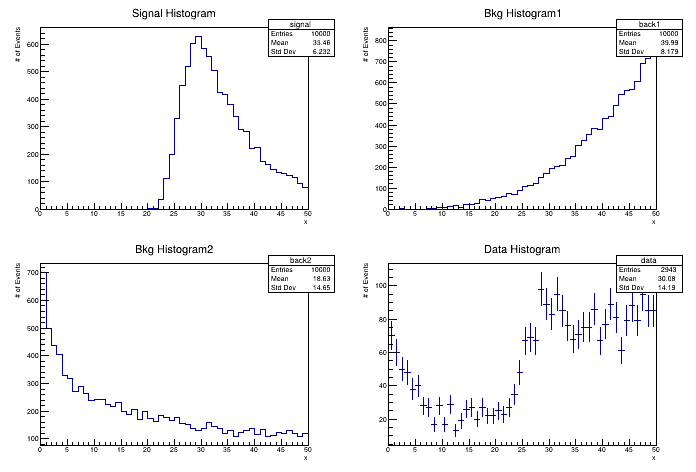

In [3]:
tf=R.TFile("mydata.root")
tc=R.TCanvas()
tc.Divide(2,2)
tc.cd(1); tf.Get("signal").Draw()
tc.cd(2); tf.Get("back1").Draw()
tc.cd(3); tf.Get("back2").Draw()
tc.cd(4); tf.Get("data").Draw("e")
tc.Draw()

Here we perform the template fit.

fit status:  0
Minuit2Minimizer: Minimize with max-calls 1345 convergence for edm < 0.01 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = -142521.631970302609
Edm   = 1.2191899307870031e-06
Nfcn  = 65
frac0	  = 0.337559	 +/-  0.0196746
frac1	  = 0.372214	 +/-  0.0157241
frac2	  = 0.290254	 +/-  0.0188561


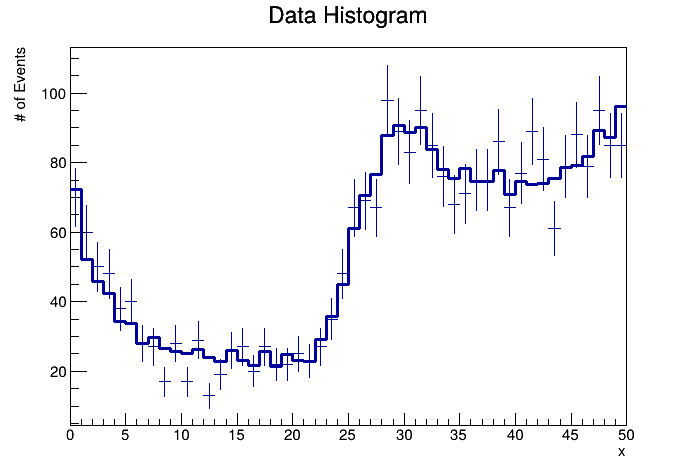

In [4]:
tcfit=R.TCanvas()

R.gStyle.SetOptStat(R.kFALSE)

tf=R.TFile("mydata.root")  #open histogram file

data=tf.Get("data")   # data histogram
mc0=tf.Get("back1")   # first MC histogram
mc1=tf.Get("back2")   # second MC histogram
msig=tf.Get("signal") # signal model

# build our model, signal and background components
model = R.TObjArray(3)   # MC histograms are put in this array
model.Add(mc0)
model.Add(mc1)
model.Add(msig)

fit = R.TFractionFitter(data, model)   # initialize the fitter
#fit.Constrain(1,0.0,0.9)           # example to constrain fraction of mc1 to be between 0 and 0.9
#fit.SetRangeX(1,15)                # example to use only the first 15 bins in the fit
status = int(fit.Fit())             # perform the fit, get status from Minuit
print("fit status: ",status)

if status == 0:                     # check on fit status
    result = fit.GetPlot()
    result.SetLineWidth(3)
    data.Draw("Ep")
    result.Draw("same")

In [5]:
# retrieve the histograms (we could also use the original mc0, mc1, etc) 
h0=fit.GetMCPrediction(0)
h1=fit.GetMCPrediction(1)
h2=fit.GetMCPrediction(2)

# retreive the fit results
# fractions contains the fraction of each component that best represents the data
fractions=[c_double(),c_double(),c_double()]     # needed b/c data are passed by reference below
errors=[c_double(),c_double(),c_double()]
ndata=data.Integral()
fit.GetResult(0,fractions[0],errors[0])
fit.GetResult(1,fractions[1],errors[1])
fit.GetResult(2,fractions[2],errors[2])

Below we build the model with normalizations from the fit and make an overlay with the data.

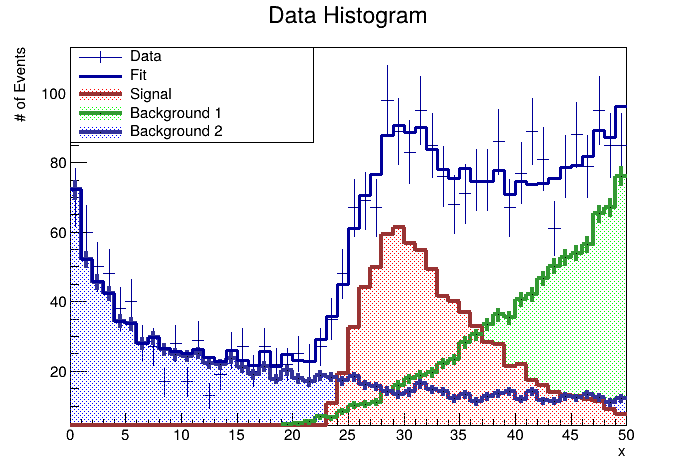

In [6]:
tcsum=R.TCanvas()

# below we normalize the MC histograms based on the # of events in the data
h0.Scale( 1./h0.Integral() * fractions[0].value*ndata )
h0.SetLineColor(R.kGreen-2)
h0.SetLineWidth(4)
h00=h0.Clone()
h0.SetFillColor(R.kGreen)
h0.SetFillStyle(3003)

h1.Scale( 1./h1.Integral() * fractions[1].value*ndata )
h1.SetLineColor(R.kBlue-2)
h1.SetLineWidth(4)
h11=h1.Clone()
h1.SetFillColor(R.kBlue)
h1.SetFillStyle(3003)

h2.Scale( 1./h2.Integral() * fractions[2].value*ndata )
h2.SetLineColor(R.kRed-2)
h2.SetLineWidth(4)
h22=h2.Clone()
h2.SetFillColor(R.kRed)
h2.SetFillStyle(3003)

# make a stack plot to show the results
hs=R.THStack("hs","stacked MC histograms")
hs.Add(h0)
hs.Add(h1)
hs.Add(h2)

data.Draw("Ep")
hs.Draw("nostack,same,hist")    # signal alone
h00.Draw("same")                # background 1 alone
h11.Draw("same")                # background 2 alone
result.Draw("same")

leg = R.TLegend(0.1,0.7,0.45,0.9)
leg.AddEntry(data,"Data","EL")
leg.AddEntry(result,"Fit","L")
leg.AddEntry(h2,"Signal")
leg.AddEntry(h0,"Background 1")
leg.AddEntry(h1,"Background 2")

leg.Draw()

tcsum.Draw()

Finally, we extract the information of interest.

In [7]:
print("\n***** Signal summary *****");
print("Number of signal events = ",h2.Integral(),"+-",errors[2].value*h2.Integral())


***** Signal summary *****
Number of signal events =  805.7450815737247 +- 15.193213307539265
